# GPGN470/570, Spring 2020

# This demo shows an example of classifying an image and using the classification to mask the image

# M. Siegfried (siegfried@mines.edu)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.signal

# Import two different classifying algorithms
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.ensemble import RandomForestClassifier

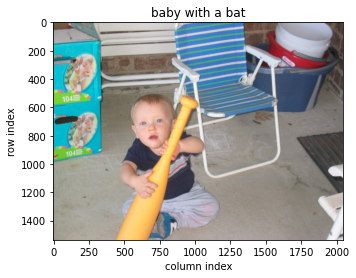

In [2]:
# Load and plot the picture of a baby holding a bat
z=plt.imread('demo.jpg') # this loads the image as an [MxNx3] matrix (where 1:3 = R,G,B)
plt.imshow(z)
plt.xlabel('column index')
plt.ylabel('row index')
plt.title('baby with a bat')
plt.show()

In [3]:
#
# CREATE A TRAINING SET
# Identify the location (column,row) of "training pixels" and assign them a "group number":
# For the sake of time, we're just going to identify two training pixels per group
#
# The last cell of this notebook has some code that demonstrates how to make an 
# interactive plot where you click on the image and it spits out the pixel location
# into a numpy array named "coords". Then it's just a question of appending group numbers
# to that numpy array.
# 
tpix=np.array([[640,1309,1], # Group 1: Yellow Bat
      [ 755,1218,1], 
      [1409,1351,2], # Group 2: Grey Concrete
      [ 673, 394,2],
      [1762, 285,3], # Group 3: Red Tub
      [1542, 177,3],
      [1754, 538,4], # Group 4: Blue Tub
      [1811, 432,4],
      [2010,1417,5], # Group 5: White Tub
      [1733, 163,5],
      [ 677, 652,6], # Group 6: Baby
      [1032, 864,6],
      [1882, 836,7], # Group 7: Dark Doormat
      [1917,1063,7]]) 

group_names=['yellow bat',
             'grey concrete',
             'red tub',
             'blue tub',
             'white tub',
             'baby',
             'dark doormat']


In [4]:
# Time to classify. We need to massage the training set a bit first...

train = z[tpix[:,1],tpix[:,0],:] # band values at the training points
group = tpix[:,2] # group value at the training point
train=train.astype(float) # need floats instead of ints
ngroup=group.max()

# initalize the algorithm with the training data. we're going to use a 
# linear discriminant classifier, which is super fast
LDA  = LinearDiscriminantAnalysis()
LDA.fit_transform(train,group)

# Now predict the classes for the rest of the image.
# First step is to reshape the picture into an ([nx*ny] x n_bands)-sized array
new_shape = ( z.shape[0]*z.shape[1], z.shape[2])
allpix = z[:, :, :].astype(float).reshape(new_shape)

# Classifying is just a quesiton of throwing your reshaped matrix into the algorithm
# But don't forget to reshape the classified image back into the right shape!
classified_lda=LDA.predict(allpix)
classified_lda = classified_lda.reshape(z[:,:,0].shape)

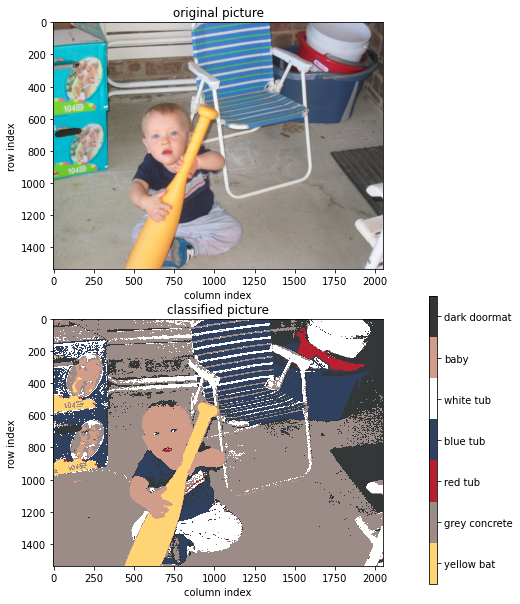

In [5]:
# Now lets plot the classified image. 

# Set up a look up table for class => color  (as RGB)
colors = np.array([[255,212,116],
        [155,140,135],
        [183, 32, 47],
        [ 48, 65, 95],
        [255,255,255],
        [209,156,138],
        [ 51, 55, 56]])
# Python needs 0-1 and not 0-255
colors=colors/255.0

# Make a colormap from the list of colors 
classmap = plt.matplotlib.colors.ListedColormap(colors, 'Classification', ngroup)

# plot the results as a two panel subplot (image on top, classified image on bottom)
fig, (ax1,ax2) = plt.subplots(2,1) # set up your axes
fig.set_figheight(10) # make the figure bigger

# plot the original picture on top
ax1.imshow(z)
ax1.set_ylabel('row index')
ax1.set_xlabel('column index')
ax1.set_title('original picture')

# plot the classified picture on bottom using the colormap you just made
im = ax2.imshow(classified_lda, cmap=classmap, interpolation='none')
ax2.set_title('classified picture')
ax2.set_ylabel('row index')
ax2.set_xlabel('column index')

# show the classification colorbar
cax = plt.axes([1, 0.1, 0.02, 0.4]) # set colorbar position and size
cbar=plt.colorbar(im, cax=cax) # plot the colorbar
cbar.set_ticks(np.linspace(1+3/7,7-3/7,7)) # adjust ticks. Some fancy math to get ticks in center
cbar.set_ticklabels(group_names) # use the group names as the tick labels
plt.show()

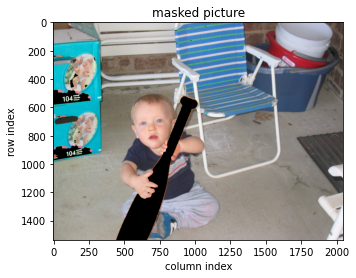

In [6]:
# Mask the picture to show the whole picture except the bat

# create a boolean mask: True if (not bat). False if bat.
msk=classified_lda!=1

# multiply each band by the boolean mask
r_mask=np.multiply(z[:,:,0],msk)
g_mask=np.multiply(z[:,:,1],msk)
b_mask=np.multiply(z[:,:,2],msk)

# recombine the bands into an MxNx3 matrix and show the image
plt.imshow(np.stack((r_mask,g_mask,b_mask),axis=2))
plt.ylabel('row index')
plt.xlabel('column index')
plt.title('masked picture')
plt.show()

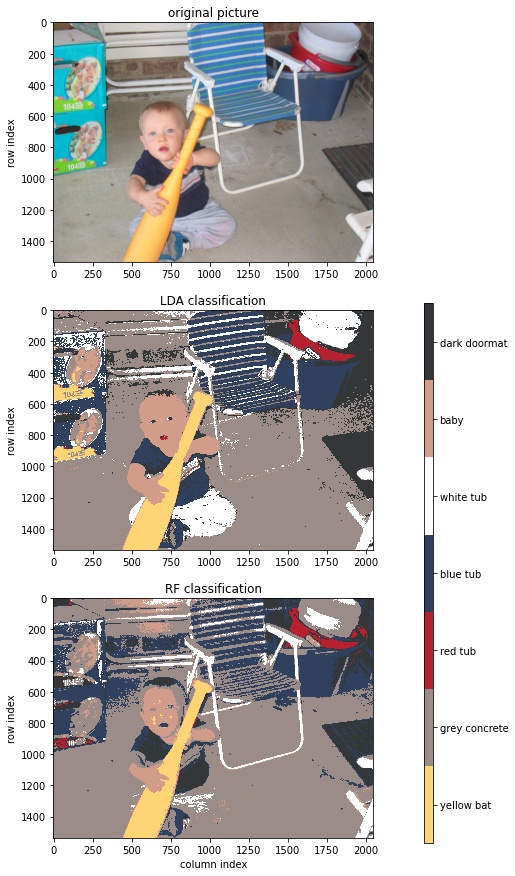

In [7]:
### Let's do the classification again, but this time for the machine learning
### folks in the class. Let's use a random forest classifier. 
### Random forests are nice because they are highly parallelizable 

# Initialize our model with 100 trees. n_jobs=-1 says use all the cores you can find!
rf = RandomForestClassifier(n_estimators=100,n_jobs=-1)

# Fit our model to training data, just like in the earlier example
train = z[tpix[:,1],tpix[:,0],:] # band values at the training points
group = tpix[:,2] # group value at the training point
train=train.astype(float) # need floats instead of ints
ngroup=group.max()

rf = rf.fit(train,group)

# reshape picture into [nx*ny] x n_bands array
new_shape = ( z.shape[0]*z.shape[1], z.shape[2])
allpix = z[:, :, :].astype(float).reshape(new_shape)

# predict the classes and reshape the output into the shape of the image
classified_rf = rf.predict(allpix)
classified_rf = classified_rf.reshape(z[:,:,0].shape)

# plot the results as a three panel subplot 
# (image on top, LDA classified in the middle, RF classified on bottom)
fig, (ax1,ax2,ax3) = plt.subplots(3,1) # set up your axes
fig.set_figheight(15) # make the figure bigger


# plot the original picture on top
ax1.imshow(z)
ax1.set_ylabel('row index')
ax1.set_title('original picture')

# plot the LDA classified picture in the middle using the colormap
im = ax2.imshow(classified_lda, cmap=classmap, interpolation='none')
ax2.set_title('LDA classification')
ax2.set_ylabel('row index')

# plot the RF classified picture on bottom using the colormap
im = ax3.imshow(classified_rf, cmap=classmap, interpolation='none')
ax3.set_title('RF classification')
ax3.set_ylabel('row index')
ax3.set_xlabel('column index')

# show the classification colorbar
cax = plt.axes([1, 0.12, 0.02, 0.5]) # set colorbar position and size
cbar=plt.colorbar(im, cax=cax) # plot the colorbar
cbar.set_ticks(np.linspace(1+3/7,7-3/7,7)) # adjust ticks. Some fancy math to get ticks in center
cbar.set_ticklabels(group_names) # use the group names as the tick labels
plt.show()

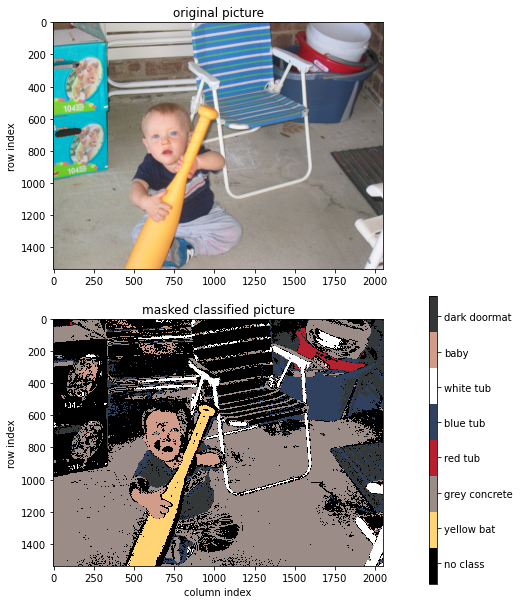

In [8]:
# Just for fun, let's mask the RF classification based on the probability 
probs=rf.predict_proba(allpix)

# the RF classifier gives a probability for each group. Let's just take the 
# the maximum probability of all groups at each pixel (since that's how it classifies)

# reshape into an M x N x n_groups matrix
probs_shaped=np.reshape(probs,(z.shape[0],z.shape[1],probs.shape[1]))
# grab the max along the 3rd axis (n_groups)
max_probs=np.amax(probs_shaped,2)

# create a boolean mask: we only want to use the classification if 
# the algorithm is >50% sure of its decision
msk=max_probs>0.5

# Set up a new look up table, where 0 is no class (black).
colors = np.array([[0,0,0],
        [255,212,116],
        [155,140,135],
        [183, 32, 47],
        [ 48, 65, 95],
        [255,255,255],
        [209,156,138],
        [ 51, 55, 56]])
# Python needs 0-1 and not 0-255
colors=colors/255.0

# Make a colormap from the list of colors 
classmap_new = plt.matplotlib.colors.ListedColormap(colors, 'Classification', ngroup+1)

# plot the results as a three panel subplot 
# (image on top, LDA classified in the middle, RF classified on bottom)
fig, (ax1,ax2) = plt.subplots(2,1) # set up your axes
fig.set_figheight(10) # make the figure bigger


# plot the original picture on top
ax1.imshow(z)
ax1.set_ylabel('row index')
ax1.set_title('original picture')

# mask the classified image and show it
im = plt.imshow(np.multiply(classified_rf,msk), cmap=classmap_new, interpolation='none')
cax = plt.axes([1, 0.1, 0.02, 0.4]) # set colorbar position and size
cbar = plt.colorbar(im, cax=cax)
cbar.set_ticks(np.linspace(0.5,6.5,8)) # adjust ticks. Some fancy math to get ticks in center
cbar.set_ticklabels(['no class']+group_names) # use the group names as the tick labels
ax2.set_title('masked classified picture')
ax2.set_ylabel('row index')
ax2.set_xlabel('column index')


plt.show()

<IPython.core.display.Javascript object>


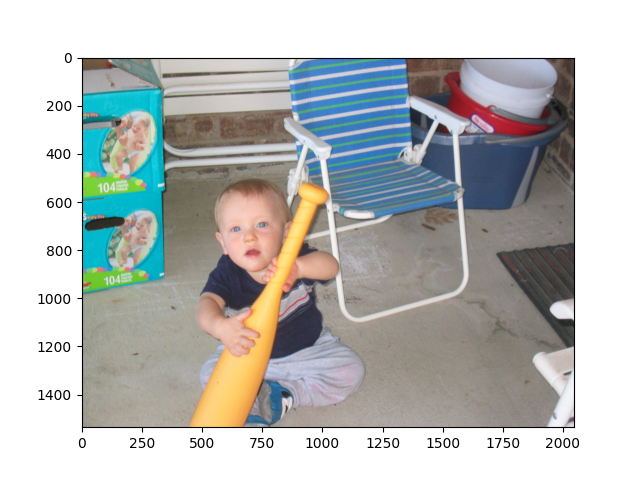

In [9]:
#### EXAMPLE CODE SNIPPET THAT POPS UP AN INTERACTIVE PLOT THAT YOU CAN CLICK
#### AND GET PIXEL LOCATIONS INTO A NUMPY ARRAY NAMED coords
#### This is obviously the most user-intensive way of getting training pixels

# this turns it into an interactive plot. 
# use inline instead of notebook to go back to non-interactive
%matplotlib notebook 

coords=np.array([]) # initialize an empty array for the coordinates to go into

# define what happens when there's a click event
def onclick(event):
    global ix, iy, coords, text
    ix, iy = int(round(event.xdata)), int(round(event.ydata)) # store x,y location
    tx="x = {}, y = {}".format(ix, iy) # string to print on the figure
    
    # if this is your first click, initialize the coords array and the text on figure
    # otherwise, just append the new coordinates and replace the text on the figure
    if coords.shape[0]==0:
        coords=np.array([ix,iy])
        text=ax.text(0,0,tx,va="bottom",ha="left")
    else:
        coords=np.vstack([coords,[ix,iy]])
        text.set_text(tx)
    return coords


# set up a figure that has a listener for clicking the mouse.
fig = plt.figure()
ax = fig.add_subplot(111)
ax.imshow(z)
fig.canvas.mpl_connect('button_press_event',onclick)
plt.show()
